# About

# Preparation

## Libraries

In [1]:
import pandas as pd

In [2]:
from dotenv import load_dotenv
import os
from pathlib import Path

In [3]:
from src.core.transforms import (
    transform_transactions_df,
    transform_customers_df,
    get_customers_screenshot_summary_from_transactions_df,
    add_churn_status,
)

In [4]:
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions

In [5]:
import maika_eda_pandas as mk

In [6]:
import mlflow

In [50]:
from sklearn.metrics import (
    average_precision_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

In [181]:
import cloudpickle
import tempfile

## Environment

In [7]:
load_dotenv()

True

In [8]:
SEED_CUSTOMERS=os.getenv("SEED_CUSTOMERS")
SEED_TRANSACTIONS=os.getenv("SEED_TRANSACTIONS")

In [9]:
OBSERVED_DATE = pd.Timestamp('2025-12-31')
OBSERVED_DATE_STR = OBSERVED_DATE.strftime("%d_%m_%Y")

In [10]:
PROJECT_ROOT = Path.cwd().parent

In [11]:
BASE_GOLD_DIR = PROJECT_ROOT / "data" / "gold" / OBSERVED_DATE_STR

In [12]:
MLRUNS_DIR = PROJECT_ROOT / "mlruns"

In [13]:
EXPERIMENT_NAME = "bg-nbd"

In [14]:
mlflow.set_tracking_uri(f"file://{MLRUNS_DIR}")

In [15]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

## Wrappers

In [16]:
def get_lifetimes_summary_df(
    transactions_df: pd.DataFrame,
    observed_date: pd.Timestamp,
    column_names: list
) -> pd.DataFrame:
    """
    Build a per-customer snapshot summary from a transactions DataFrame.

    The function filters transactions up to the observed date and computes,
    per customer:
        - first transaction date in the period
        - last transaction date in the period
        - number of transactions in the period

    Parameters
    ----------
    transactions_df : pd.DataFrame
        Input transactions data.
    observed_date : pd.Timestamp
        Cutoff date for the snapshot.
    column_names : list
        Column names in the following order:
        [customer_id, transaction_date]

    Returns
    -------
    pd.DataFrame
        Customer-level snapshot summary.
    """

    customer_col, transaction_date_col = column_names

    filtered_df = transactions_df[
        transactions_df[transaction_date_col] <= observed_date
    ]

    summary_df = (
        filtered_df
        .groupby(customer_col, as_index=False)
        .agg(
            period_first_transaction_date=(transaction_date_col, 'min'),
            period_last_transaction_date=(transaction_date_col, 'max'),
            frequency=(customer_col, 'size')
        )
    )

    summary_df['frequency'] = summary_df['frequency'] - 1


    summary_df['T'] = (
        observed_date - summary_df['period_first_transaction_date']
    ).dt.days

    summary_df['recency'] = (
        summary_df['period_last_transaction_date']
        -
        summary_df['period_first_transaction_date']
    ).dt.days

    return summary_df[[customer_col, 'frequency', 'T', 'recency']]

In [17]:
def get_lifetimes_summary_arrays(summary_df):

    n = summary_df.shape[0]
    x = summary_df["frequency"].to_numpy()
    t_x = summary_df["recency"].to_numpy()
    T = summary_df["T"].to_numpy()

    return (n, x, t_x, T)

In [143]:
def evaluate_churn_predictions(
    feature_df: pd.DataFrame,
    target_df: pd.DataFrame | None = None,
    threshold: float = 0.5,
    target_col: str = "is_churn",
    proba_col: str = "p_churn",
):
    """
    feature_df: must contain [proba_col]
    target_df:
        - if provided: must contain [target_col]
        - if None: target_col must already be in feature_df

    Assumes customer_id is the index in both DataFrames.
    """

    # Decide where labels come from
    if target_df is None:
        missing = {target_col, proba_col} - set(feature_df.columns)
        if missing:
            raise ValueError(
                f"feature_df is missing required columns: {missing}"
            )
        eval_df = feature_df.copy()

    else:
        missing_f = {proba_col} - set(feature_df.columns)
        missing_t = {target_col} - set(target_df.columns)

        if missing_f or missing_t:
            raise ValueError(
                f"Missing columns — "
                f"feature_df: {missing_f}, target_df: {missing_t}"
            )

        # Index-based alignment
        eval_df = feature_df.join(
            target_df[[target_col]],
            how="inner"
        )

    # Binary predictions
    eval_df["pred_churn"] = (eval_df[proba_col] >= threshold).astype(int)

    # Metrics
    metrics = {
        "roc_auc": roc_auc_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "pr_auc": average_precision_score(
            eval_df[target_col],
            eval_df[proba_col]
        ),
        "precision": precision_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
        "recall": recall_score(
            eval_df[target_col],
            eval_df["pred_churn"]
        ),
    }

    # Confusion matrix
    cm = confusion_matrix(
        eval_df[target_col],
        eval_df["pred_churn"]
    )

    cm_df = pd.DataFrame(
        cm,
        index=["actual_no_churn", "actual_churn"],
        columns=["pred_no_churn", "pred_churn"]
    )

    return metrics, cm_df, eval_df

In [56]:
from sklearn.model_selection import train_test_split

def split_train_test_val(
    customers_modeling_df,
    targets,
    test_size=0.33,
    val_size=0.33,
    random_state=42,
):
    """
    Split customer modeling dataframe into train / val / test sets.

    Parameters
    ----------
    customers_modeling_df : pd.DataFrame
        Must contain customer_id and target columns.
    targets : list[str]
        Target column names.
    test_size : float
        Proportion of data used for test+val split.
    val_size : float
        Proportion of test split used for validation.
    random_state : int

    Returns
    -------
    X_train, X_val, X_test, y_train, y_val, y_test
    """

    # -------------------------------
    # Feature / target separation
    # -------------------------------
    X_df = customers_modeling_df.drop(columns=targets)
    X_df = X_df.set_index("customer_id", drop=True)

    y_df = customers_modeling_df[["customer_id"] + targets]
    y_df = y_df.set_index("customer_id", drop=True)

    # -------------------------------
    # Train / temp split
    # -------------------------------
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_df,
        y_df,
        test_size=test_size,
        random_state=random_state,
    )

    # -------------------------------
    # Test / validation split
    # -------------------------------
    X_test, X_val, y_test, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=val_size,
        random_state=random_state,
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [184]:
def train_bg_nbd(
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | None = None,
    X_val: pd.DataFrame | None = None,
    y_val: pd.DataFrame | None = None,
    X_test: pd.DataFrame | None = None,
    y_test: pd.DataFrame | None = None,
    target: str = "p_alive",
    threshold: float = 0.5,
):
    """
    Trains a BG-NBD model and evaluates churn when labels are available.

    Assumptions:
    - X_* index = customer_id
    - X_* contain ['frequency', 'recency', 'T']
    - y_* contain ['is_churn'] and share index with X_*
    """

    # ======================
    # Train BG-NBD
    # ======================
    bgf = BetaGeoFitter()
    bgf.fit(
        frequency=X_train["frequency"],
        recency=X_train["recency"],
        T=X_train["T"],
    )

    # ======================
    # Add predictions (IN PLACE)
    # ======================
    X_train.loc[:, target] = bgf.conditional_probability_alive(
        X_train["frequency"],
        X_train["recency"],
        X_train["T"],
    )
    X_train.loc[:, "p_churn"] = 1.0 - X_train[target]

    if X_val is not None:
        X_val.loc[:, target] = bgf.conditional_probability_alive(
            X_val["frequency"],
            X_val["recency"],
            X_val["T"],
        )
        X_val.loc[:, "p_churn"] = 1.0 - X_val[target]

    if X_test is not None:
        X_test.loc[:, target] = bgf.conditional_probability_alive(
            X_test["frequency"],
            X_test["recency"],
            X_test["T"],
        )
        X_test.loc[:, "p_churn"] = 1.0 - X_test[target]

    # ======================
    # Evaluation helper (inline, no copies)
    # ======================
    def evaluate(X, y, split_name):
        eval_df = X.join(y, how="inner")

        eval_df.loc[:, "pred_churn"] = (
            eval_df["p_churn"] >= threshold
        ).astype(int)

        metrics = {
            "roc_auc": roc_auc_score(
                eval_df["is_churn"],
                eval_df["p_churn"],
            ),
            "pr_auc": average_precision_score(
                eval_df["is_churn"],
                eval_df["p_churn"],
            ),
            "precision": precision_score(
                eval_df["is_churn"],
                eval_df["pred_churn"],
            ),
            "recall": recall_score(
                eval_df["is_churn"],
                eval_df["pred_churn"],
            ),
        }

        cm = confusion_matrix(
            eval_df["is_churn"],
            eval_df["pred_churn"],
        )

        cm_df = pd.DataFrame(
            cm,
            index=["actual_no_churn", "actual_churn"],
            columns=["pred_no_churn", "pred_churn"],
        )

        # MLflow logging
        for k, v in metrics.items():
            mlflow.log_metric(f"{split_name}_{k}", v)

        mlflow.log_text(
            cm_df.to_string(),
            artifact_file=f"confusion_matrix/{split_name}_churn.txt",
        )

        return metrics, cm_df

    results = {
        "model": bgf,
        "train": X_train,
    }

    # ======================
    # Validation evaluation
    # ======================
    if X_val is not None and y_val is not None:
        results["val"] = evaluate(X_val, y_val, "val")

    # ======================
    # Test evaluation
    # ======================
    if X_test is not None and y_test is not None:
        results["test"] = evaluate(X_test, y_test, "test")

    # ======================
    # MLflow model logging (correct for BG-NBD)
    # ======================
    mlflow.log_param("model_type", "BG-NBD")
    mlflow.log_param("target", target)
    mlflow.log_param("threshold", threshold)

    mlflow.log_param("model_type", "BG-NBD")
    log_bg_nbd_model(bgf)

    return results

In [183]:
def log_bg_nbd_model(bgf):
    with tempfile.TemporaryDirectory() as tmpdir:
        path = Path(tmpdir) / "bg_nbd.pkl"
        with open(path, "wb") as f:
            cloudpickle.dump(bgf, f)

        mlflow.log_artifact(path, artifact_path="bg_nbd_model")

## Data

### Read Seed Data

In [19]:
transactions_df = pd.read_csv(f"../{SEED_TRANSACTIONS}")
transactions_df = transform_transactions_df(transactions_df)

In [20]:
customers_df = pd.read_csv(f"../{SEED_CUSTOMERS}")
customers_df = transform_customers_df(customers_df)

In [21]:
class_churn_prob = pd.read_csv(BASE_GOLD_DIR / "inference" / "classifier_1" / "churn_prob.csv")

### Get Summary Dataframe

In [72]:
summary_df = get_lifetimes_summary_df(
    transactions_df=transactions_df,
    observed_date=OBSERVED_DATE,
    column_names=['customer_id', 'transaction_date']
)

### Write Summary Dataframe

In [ ]:
#summary_df.to_csv(BASE_GOLD_DIR / "clv" / "summary_df.csv", index=False)

### Read Summary Dataframe

In [73]:
summary_df = pd.read_csv(BASE_GOLD_DIR / "clv" / "summary_df.csv")

### Add Churn Labels

In [75]:
customer_ids = customers_df[
    customers_df['customer_id'].isin(transactions_df['customer_id'])
].reset_index(drop=True)

In [ ]:
customer_ids = add_churn_status(
        transformed_customers_df=customer_ids,
        observed_date=OBSERVED_DATE,
        desired_df=summary_df,
)

### Split Data

In [105]:
(
    X_train,
    X_val,
    X_test,
    y_train,
    y_val,
    y_test
) = split_train_test_val(
    customers_modeling_df=customer_ids,
    targets=['is_churn'],
    test_size=0.33,
    val_size=0.33,
    random_state=42,
)

# Test

## Fit Model

In [95]:
bgf = BetaGeoFitter()
bgf.fit(frequency=X_train["frequency"], recency=X_train["recency"], T=X_train["T"])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.150514,0.039905,1.072299,1.228728
alpha,6.877404,0.288007,6.312910,7.441898
a,1.252763,0.170872,0.917854,1.587672
b,24.315390,4.325308,15.837786,32.792994


## Predict

In [133]:
X_train["p_alive"] = bgf.conditional_probability_alive(
    X_train["frequency"],
    X_train["recency"],
    X_train["T"]
)

X_train["p_churn"] = 1 - X_train["p_alive"]

In [134]:
X_test["p_alive"] = bgf.conditional_probability_alive(
    X_test["frequency"],
    X_test["recency"],
    X_test["T"]
)

X_test["p_churn"] = 1 - X_test["p_alive"]

In [135]:
X_val["p_alive"] = bgf.conditional_probability_alive(
    X_val["frequency"],
    X_val["recency"],
    X_val["T"]
)

X_val["p_churn"] = 1 - X_val["p_alive"]

## Evaluate

In [136]:
split_dfs = {
    'train': [X_train, y_train],
    'test': [X_test, y_test],
    'val': [X_val, y_val]
}

In [139]:
split_dfs['train']

[             frequency    T  recency termination_date   p_alive   p_churn
 customer_id                                                              
 C00191               0  200        0       2025-06-28  1.000000  0.000000
 C01168              20  192      156       2025-11-29  0.336171  0.663829
 C01275               4  128       28       2025-09-30  0.020152  0.979848
 C00192               3  244       31       2025-06-03  0.008145  0.991855
 C02311               4  122      115       2026-08-20  0.942376  0.057624
 ...                ...  ...      ...              ...       ...       ...
 C01697               2  276        3       2025-04-13  0.000519  0.999481
 C01135              17  291      159       2025-08-28  0.000781  0.999219
 C01172               3   30       19       2026-05-12  0.828434  0.171566
 C01345               3  190       90       2025-12-01  0.525360  0.474640
 C00895              14  319      110       2025-06-10  0.000005  0.999995
 
 [1937 rows x 6 columns

In [142]:
results_df = {}
for split in split_dfs.keys():

    print(f'Evaluation results for {split} set:')

    X = split_dfs[split][0]
    y = split_dfs[split][1]

    metrics, confusion_matrix_df, eval_df = evaluate_churn_predictions(
        feature_df=X,
        target_df=y
    )

    results_df[split] = [metrics, confusion_matrix_df]

    print(metrics)
    print(confusion_matrix_df)

Evaluation results for train set:
{'roc_auc': 0.9138542967387758, 'pr_auc': 0.9598171073819626, 'precision': 0.9715489989462592, 'recall': 0.7747899159663866}
                 pred_no_churn  pred_churn
actual_no_churn            720          27
actual_churn               268         922
Evaluation results for test set:
{'roc_auc': 0.8942387246493795, 'pr_auc': 0.9480475745877854, 'precision': 0.9790940766550522, 'recall': 0.7513368983957219}
                 pred_no_churn  pred_churn
actual_no_churn            259           6
actual_churn                93         281
Evaluation results for val set:
{'roc_auc': 0.8828931294494292, 'pr_auc': 0.9474210880970377, 'precision': 0.9602649006622517, 'recall': 0.7512953367875648}
                 pred_no_churn  pred_churn
actual_no_churn            117           6
actual_churn                48         145


Compared to our Churn Classification models (although it has less data to train, so we are being unfair) these results are incredible: PR-AUC > 0.9 and Recall > 0.7.
- Pros: High accuracy.
- Cons: Hard to perform action on. This is because BG-NBD gives instant predictions, which means we usually need instant action (ex: a customer have p_alive of 0.2). And businesses don't always have the immediate resources for that. Churn Classfication models are better in this sense because they gives a possible outlook for the future where the business can actually plan for.

## Compare Performance with Churn Classification Model

In [105]:
result_df = pd.merge(
    class_churn_prob,
    summary_df,
    on="customer_id",
    how="inner"
)

In [109]:
result_df["bg_nbd_delta_class_30d"] = result_df["p_churn"] - result_df["p_is_churn_30_days"]
result_df["bg_nbd_delta_class_60d"] = result_df["p_churn"] - result_df["p_is_churn_60_days"]
result_df["bg_nbd_delta_class_90d"] = result_df["p_churn"] - result_df["p_is_churn_90_days"]

In [107]:
stat_df = mk.distribution_statistics_table(result_df, value_col='bg_nbd_delta_class_30d')
fig = mk.create_histogram_plotly(result_df, 'bg_nbd_delta_class_30d')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

In [110]:
stat_df = mk.distribution_statistics_table(result_df, value_col='bg_nbd_delta_class_60d')
fig = mk.create_histogram_plotly(result_df, 'bg_nbd_delta_class_60d')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

In [111]:
stat_df = mk.distribution_statistics_table(result_df, value_col='bg_nbd_delta_class_90d')
fig = mk.create_histogram_plotly(result_df, 'bg_nbd_delta_class_90d')
mk.stack_plotly_figure_with_dataframe(stat_df, fig)

Comment:
- To compare the outputs fairly I have used a flexible output based on the prediction target of the classifier. Just as before, I set a fixed inference date (for these experiements, I use 31/12/2025). Then if the target is predict within 30 days, I use the data from 30 days prior to the inference date for training the models.

- As the prediction window widens (from 30 days to 90 days), the mean/mode deviance between the two approaches (BG-NBD and LGBM) grows. This reflect how a model reflects further prediction with more uncertainty (a plausible cause is a smaller training set).

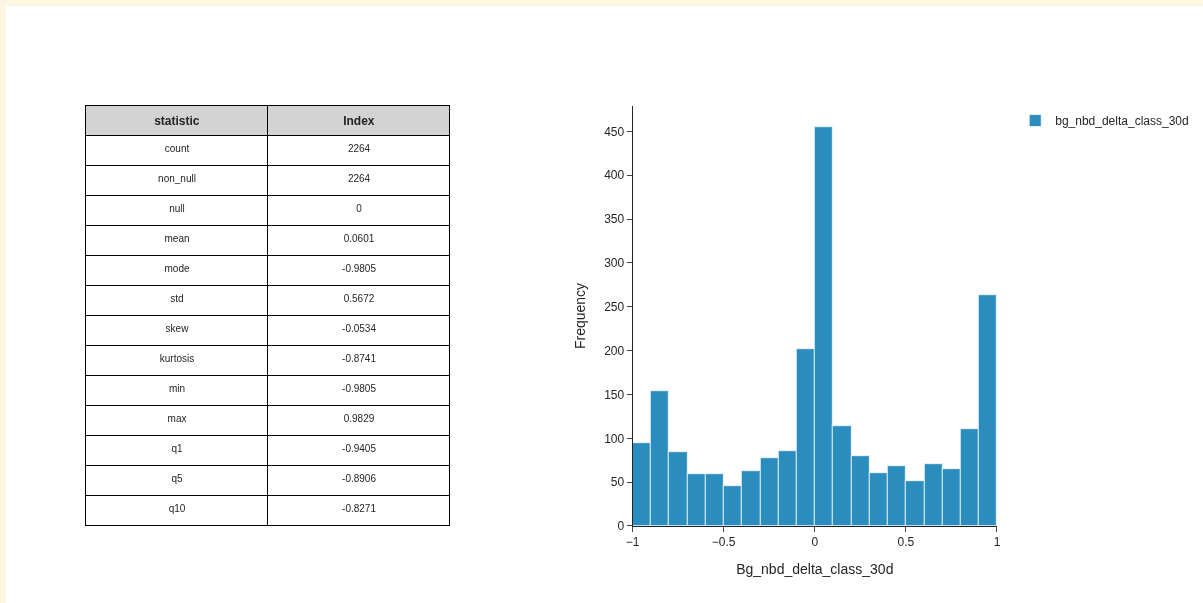
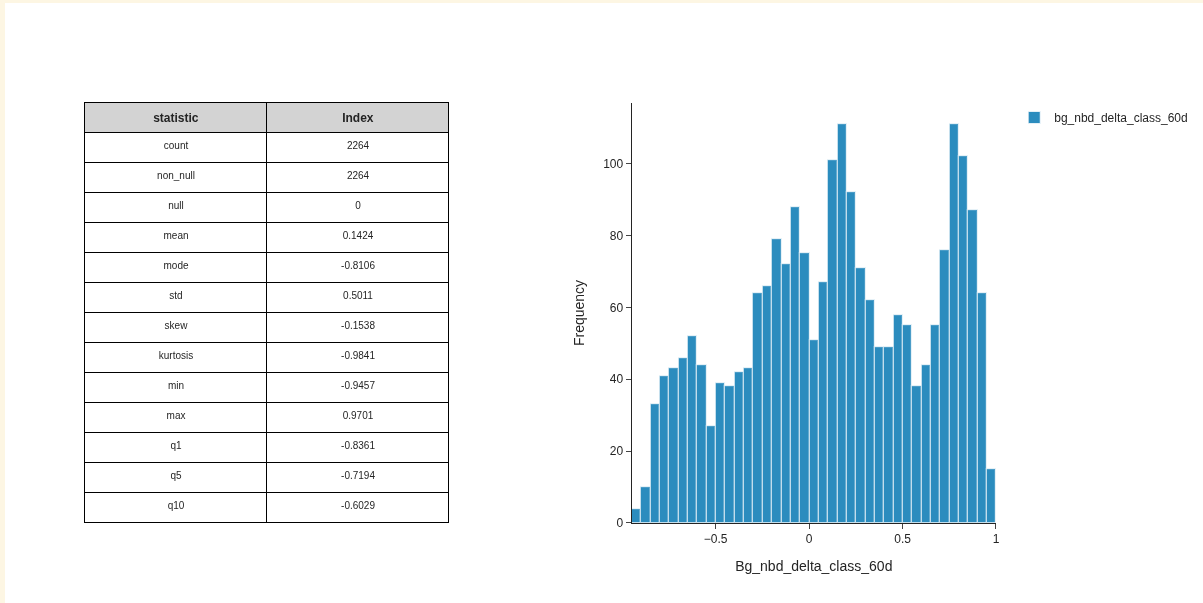
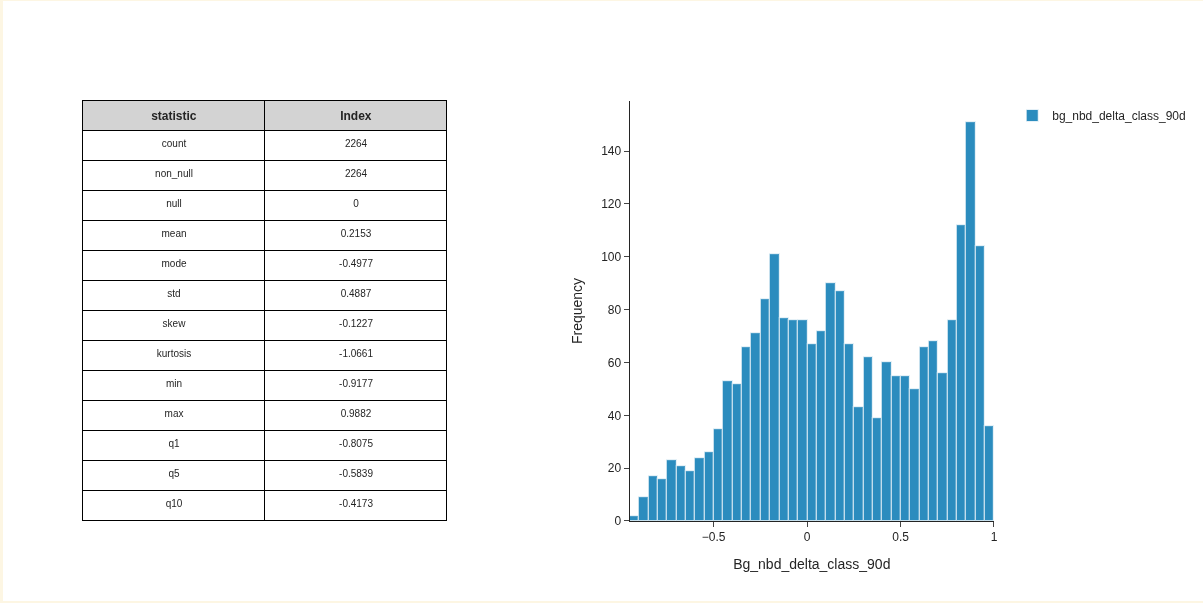

# Productionize

## Setup MLflow

In [172]:
mlflow.set_experiment(EXPERIMENT_NAME)

<Experiment: artifact_location='file:///home/hong-mai/Desktop/HONGMAI/Coding/ai-customer-growth-retention/mlruns/709690053402558735', creation_time=1768715955081, experiment_id='709690053402558735', last_update_time=1768715955081, lifecycle_stage='active', name='bg-nbd', tags={}>

## Write Data

In [ ]:
'''
for split in split_dfs.keys():
    X = split_dfs[split][0]
    y = split_dfs[split][1]
    X.to_csv(BASE_GOLD_DIR / "clv" / f"X_{split}.csv",index="True")
    y.to_csv(BASE_GOLD_DIR / "clv" / f"y_{split}.csv" ,index="True")
'''

## Read Data

In [158]:
inf_split_dfs = {
    'train':[],
    'test':[],
    'val':[]
}

In [165]:
for split in inf_split_dfs.keys():
    X = pd.read_csv(BASE_GOLD_DIR / "clv" / f"X_{split}.csv", index_col=0)
    y = pd.read_csv(BASE_GOLD_DIR / "clv" / f"y_{split}.csv", index_col=0)
    inf_split_dfs[split] = [X, y]

## Log Model

In [185]:
target = "p_alive"

with mlflow.start_run(
    run_name=f"{BASE_GOLD_DIR}_{target}"
):
    mlflow.log_param("gold_data_version", BASE_GOLD_DIR.name)

    train_bg_nbd(
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        X_test=X_test,
        y_test=y_test,
        target=target
    )

## Inference

In [ ]:
def predict_churn(
    customer_id: str,
    horizon_days: int,
    raw_features_df,
    transformed_features_by_target,
    models,
    metadata,
):
    # ------------------
    # Validate horizon
    # ------------------
    if horizon_days not in {30, 60, 90}:
        raise ValueError("horizon_days must be one of {30, 60, 90}")

    target = f"is_churn_{horizon_days}_days"

    if target not in models:
        raise KeyError(f"No production model loaded for target: {target}")

    # ------------------
    # Select features
    # ------------------
    X = get_customer_features(
        customer_ids=[customer_id],
        target=target,
        metadata=metadata,
        raw_features_df=raw_features_df,
        transformed_features_by_target=transformed_features_by_target,
    )

    # ------------------
    # Predict
    # ------------------
    model = models[target]
    churn_prob = float(model.predict_proba(X)[0, 1])

    # ------------------
    # Risk labeling (explicit, adjustable)
    # ------------------
    if churn_prob >= 0.7:
        churn_label = "high_risk"
    elif churn_prob >= 0.4:
        churn_label = "medium_risk"
    else:
        churn_label = "low_risk"

    return {
        "churn_probability": round(churn_prob, 4),
        "churn_label": churn_label,
    }